In [3]:
import pandas as pd

# Carga del dataset

df = pd.read_csv('src//datasets//dataset_dividido_rangos.csv')

# Mostrar primeras filas
df.head()

FileNotFoundError: [Errno 2] No such file or directory: '.src//datasets//dataset_dividido_rangos.csv'

Dividir datos en entrenamiento y prueba.

In [432]:
from sklearn.model_selection import train_test_split

# Dividir en características (X) y la variable objetivo (y)
X = df.drop('stroke', axis=1)
y = df['stroke']

In [ ]:
import optuna
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import KFold, cross_val_score

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



def objective(trial):
    # Definir el espacio de búsqueda
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)

    # Crear el modelo
    model = RandomForestClassifier(n_estimators=n_estimators,
                                   max_depth=max_depth,
                                   min_samples_split=min_samples_split,
                                   min_samples_leaf=min_samples_leaf,
                                   random_state=42)

    # Definir la validación cruzada (KFold)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Usar cross_val_score para evaluar con K-Fold. Aquí usamos f1_score.
    # make_scorer(f1_score) se usa para asegurarnos de calcular el f1_score.
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring=make_scorer(f1_score))

    # Retornar la media de los scores de validación cruzada
    return scores.mean()



# Crear un estudio y optimizarlo
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Verificar si el estudio ha encontrado los mejores parámetros
if study.best_params:
    # Obtener los mejores hiperparámetros
    best_params = study.best_params
    print("Best parameters:", best_params)
else:
    raise ValueError("No best parameters found. The optimization may have failed.")


Preparación y entrenamiento del modelo (RandomForest)

In [434]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Inicializar el modelo RandomForest con los mejores hiperparámetros obtenidos
rf_model = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)

# Entrenar el modelo con los datos de entrenamiento
rf_model.fit(X_train, y_train)

# Hacer predicciones con los datos de prueba
y_pred = rf_model.predict(X_test)

# Evaluar el rendimiento del modelo final
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9391304347826087
ROC-AUC Score: 0.5135850388143967
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1417
           1       0.16      0.04      0.06        78

    accuracy                           0.94      1495
   macro avg       0.55      0.51      0.52      1495
weighted avg       0.91      0.94      0.92      1495



Verificar si el modelo está balanceado

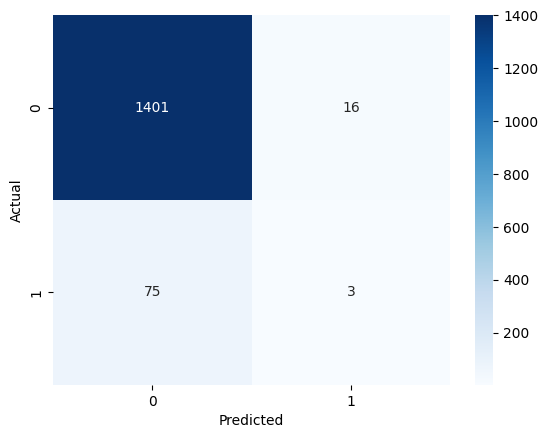

In [435]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Mostrar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Análisis del Balance de Clases

In [436]:
# Contar la clase objetivo
print(df['stroke'].value_counts(normalize=True))

stroke
0    0.950211
1    0.049789
Name: proportion, dtype: float64


Este desbalance de clases tan significativo, influye negativamente en el rendimiento del modelo, por lo que vamos a tratarlo antes del entrenamiento. Utilizaremos la técnica de Oversampling. Esta técnica aumenta la cantidad de ejemplos en la clase minoritaria mediante la replicación de ejemplos existentes o la creación de ejemplos sintéticos, como lo hace SMOTE (Synthetic Minority Over-sampling Technique).

Balanceo de clases

In [437]:
from imblearn.over_sampling import SMOTE

# Aplicar SMOTE para el balanceo de clases
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Reentrenar el modelo con los datos balanceados
rf_model_balanced = RandomForestClassifier(random_state=42)
rf_model_balanced.fit(X_train_balanced, y_train_balanced)

# Hacer predicciones nuevamente
y_pred_balanced = rf_model_balanced.predict(X_test)

# Evaluar el modelo balanceado
print("Accuracy:", accuracy_score(y_test, y_pred_balanced))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_balanced))
print(classification_report(y_test, y_pred_balanced))


'\n\nfrom imblearn.over_sampling import SMOTE\n\n# Aplicar SMOTE para el balanceo de clases\nsmote = SMOTE(random_state=42)\nX_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)\n\n# Reentrenar el modelo con los datos balanceados\nrf_model_balanced = RandomForestClassifier(random_state=42)\nrf_model_balanced.fit(X_train_balanced, y_train_balanced)\n\n# Hacer predicciones nuevamente\ny_pred_balanced = rf_model_balanced.predict(X_test)\n\n# Evaluar el modelo balanceado\nprint("Accuracy:", accuracy_score(y_test, y_pred_balanced))\nprint("ROC-AUC Score:", roc_auc_score(y_test, y_pred_balanced))\nprint(classification_report(y_test, y_pred_balanced))\n\n'

Probar con LightGBM

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import numpy as np
import optuna

# Definir la función objetivo para Optuna
def objective(trial):
    # Sugerir hiperparámetros
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'is_unbalance': True,  # Manejar el desbalance de clases
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 100),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_sum_hessian_in_leaf': trial.suggest_float('min_sum_hessian_in_leaf', 1e-3, 10)
    }

    # Validación cruzada KFold
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Crear dataset para LightGBM
    lgb_train = lgb.Dataset(X_train_balanced, label=y_train_balanced)

    # Entrenar el modelo
    lgb_model = lgb.train(param, lgb_train, num_boost_round=100)

    # Predecir
    y_pred_lgb = lgb_model.predict(X_test)
    y_pred_lgb_binary = (y_pred_lgb > 0.5).astype(int)

    # Evaluar el F1-score (puedes cambiar esta métrica si deseas optimizar otra cosa)
    return roc_auc_score(y_test, y_pred_lgb_binary)

# Crear un estudio de Optuna y optimizarlo
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Imprimir los mejores hiperparámetros
print("Best parameters:", study.best_params)

In [440]:
# Obtener los mejores parámetros
best_params = study.best_params

# Agregar otros parámetros necesarios
best_params.update({
    'objective': 'binary',
    'metric': 'binary_logloss',
    'is_unbalance': True  # Mantener el manejo del desbalance de clases
})

# Crear el dataset para LightGBM
lgb_train = lgb.Dataset(X_train_balanced, label=y_train_balanced)

# Entrenar el modelo con los mejores parámetros
lgb_model = lgb.train(best_params, lgb_train, num_boost_round=100)

# Hacer predicciones
y_pred_lgb = lgb_model.predict(X_test)
y_pred_lgb_binary = (y_pred_lgb > 0.5).astype(int)

# Evaluar el rendimiento del modelo
print("LightGBM Accuracy:", accuracy_score(y_test, y_pred_lgb_binary))
print("LightGBM ROC-AUC Score:", roc_auc_score(y_test, y_pred_lgb_binary))
print(classification_report(y_test, y_pred_lgb_binary))

[LightGBM] [Info] Number of positive: 3272, number of negative: 3316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,000355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 28
[LightGBM] [Info] Number of data points in the train set: 6588, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,496661 -> initscore=-0,013358
[LightGBM] [Info] Start training from score -0,013358
LightGBM Accuracy: 0.7879598662207358
LightGBM ROC-AUC Score: 0.5731592566454952
              precision    recall  f1-score   support

           0       0.96      0.81      0.88      1417
           1       0.09      0.33      0.14        78

    accuracy                           0.79      1495
   macro avg       0.52      0.57      0.51      1495
weighted avg       0.91      0.79      0.84      1495



Feature importances

In [442]:
# Obtener las importancias de las características
importances = lgb_model.feature_importance()
feature_names = X.columns

# Crear un DataFrame para visualizarlas
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Mostrar las características más importantes
print(feature_importance_df)

          Feature  Importance
9   glucose_group         811
6  smoking_status         754
4       work_type         700
8       bmi_group         676
0          gender         505
7       age_group         440
5  Residence_type         403
3    ever_married         250
1    hypertension         234
2   heart_disease         127


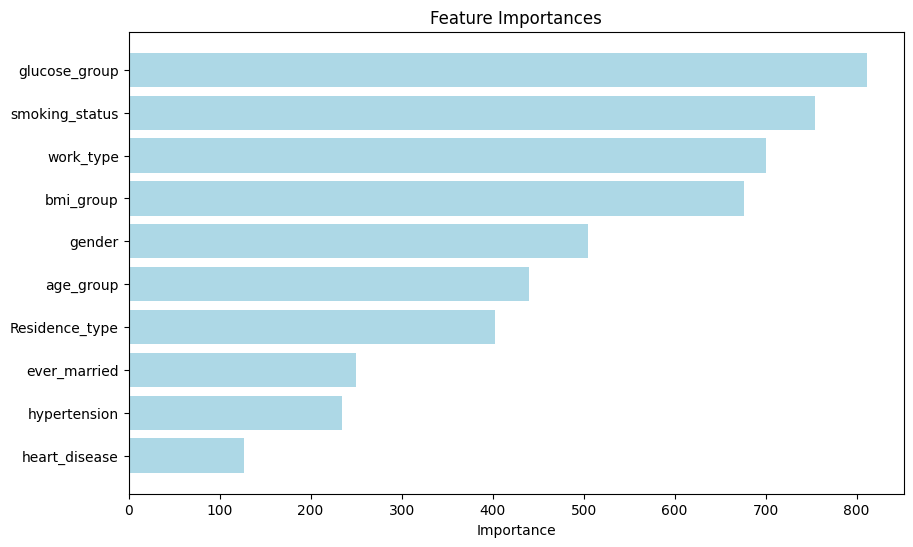

In [443]:
# Visualizar las importancias
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='lightblue')
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invertir el eje y para que la característica más importante esté arriba
plt.show()